#Deep Interactive Evolution

This colab is an unofficial implementation of the "Deep Interactive Evolution" Paper

![testo del link](https://storage.googleapis.com/groundai-web-prod/media%2Fusers%2Fuser_76290%2Fproject_252337%2Fimages%2Fx1.png) 

We'll consider two models of which we are going to "evolve" the embeddings

* CelebA Progressive GAN Model
* MusicVAE




In [2]:
import imageio
import PIL.Image
import matplotlib.pyplot as plt
import PIL

# Imports

In [3]:
#@title Imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import glob

BASE_DIR = "gs://download.magenta.tensorflow.org/models/music_vae/colab2"

print('Installing dependencies...')
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -q pyfluidsynth
!pip install -qU magenta

# Hack to allow python to pick up the newly-installed fluidsynth lib.
# This is only needed for the hosted Colab environment.
import ctypes.util
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library


print('Importing libraries and defining some helper functions...')
from google.colab import files
import magenta.music as mm
from magenta.models.music_vae import configs
from magenta.models.music_vae.trained_model import TrainedModel
import numpy as np
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import tensorflow as tf

# Necessary until pyfluidsynth is updated (>1.2.5).
import warnings
warnings.filterwarnings("ignore", category=Warning)

def play(note_sequence):
  mm.play_sequence(note_sequence, synth=mm.fluidsynth)

def interpolate(model, start_seq, end_seq, num_steps, max_length=32,
                assert_same_length=True, temperature=0.5,
                individual_duration=4.0):
  """Interpolates between a start and end sequence."""
  note_sequences = model.interpolate(
      start_seq, end_seq,num_steps=num_steps, length=max_length,
      temperature=temperature,
      assert_same_length=assert_same_length)

  print('Start Seq Reconstruction')
  play(note_sequences[0])
  print('End Seq Reconstruction')
  play(note_sequences[-1])
  print('Mean Sequence')
  play(note_sequences[num_steps // 2])
  print('Start -> End Interpolation')
  interp_seq = mm.sequences_lib.concatenate_sequences(
      note_sequences, [individual_duration] * len(note_sequences))
  play(interp_seq)
  mm.plot_sequence(interp_seq)
  return interp_seq if num_steps > 3 else note_sequences[num_steps // 2]

def download(note_sequence, filename):
  mm.sequence_proto_to_midi_file(note_sequence, filename)
  files.download(filename)

print('Done')

Installing dependencies...
Importing libraries and defining some helper functions...


/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


Done


# Part I CelebA Progressive GAN Model

[Progressive GAN](https://arxiv.org/abs/1710.10196) model that maps N-dimensional latent vectors to RGB images, which in this case correspond to photos of celebrities

We'll use a [TensorFlow Hub](https://www.tensorflow.org/hub) pre-trained model to take advantage of the model.

> Blocco con rientro



In [4]:
!pip install -q git+https://github.com/tensorflow/docs

from tensorflow_docs.vis import embed

In [5]:
# Code to plot images and animations...
def display_image(image):
  image = tf.constant(image)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return PIL.Image.fromarray(image.numpy())


def animate(images):
  images = np.array(images)
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  return embed.embed_file('./animation.gif')

Load the TensorFlow Hub model

In [6]:
import tensorflow_hub as hub
progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']


The model takes as input a vector of latent_dim=512 elements extracted from a normal distribution

In [7]:
latent_dim = 512

try to run the following cell several times and see how the results change, each time you generate a different latent vector, you obtain a different image as output.

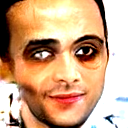

In [8]:
z = tf.random.normal([latent_dim])
output_img = progan(z)['default']
display_image(output_img[0])

Latent vectors (or embeddings) correspond to image representations in multidimensional spaces we can interpolate between them and "merge" different images

In [9]:
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)

Let us consider two latent vectors

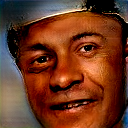

In [10]:
z1 = tf.random.normal([latent_dim])
output_img = progan(z1)['default']
display_image(output_img[0])

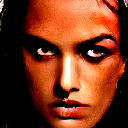

In [11]:
z2 = tf.random.normal([latent_dim])
output_img = progan(z2)['default']
display_image(output_img[0])

They correspond to two diffewrent images, we can interpolate btw the two vectors to change one image in the other one

In [12]:
# Creates a tensor with 50 steps of interpolation between v1 and v2.
interpolated_vectors = interpolate_hypersphere(z1, z2, 50)

# Uses module to generate images from the latent space.
interpolated_images = progan(interpolated_vectors)['default']


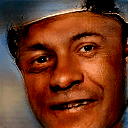

In [13]:
animate(interpolated_images)

### Deep Interactive Evolution with CelebA

Now we start applying the Deep Interactive evolution model to celebA

### Uniform Crossover: FILL THE CODE

Two parents are randomly selected and an offspring is generated by choosing from two parents with equal probablity

In [14]:
# Generate a population of vectors of size pop_len X latent_dim
pop_len = 10
population = tf.random.normal([pop_len,latent_dim])

# Select two parents randomly from the population: FILL THE CODE
# HINT use np.random.randint
# population is a n_pop X latent_dim matrix
z1 = population[np.random.randint(0, pop_len)]
z2 = population[np.random.randint(0, pop_len)]

# Generate a binary mask using a binomial distribution with params n=1 p=0.5
# HINT: use np.random.binomial
mask = np.random.binomial(1, 0.5, latent_dim)

# Compute uniform crossover between the two parents: FILL THE CODE
# Use the computed binary mask to crossover the two vectords
crossover = mask*z1 + (1-mask)*z2

plot the result of uniform crossover

Text(0.5, 1.0, ' Uniform Crossover')

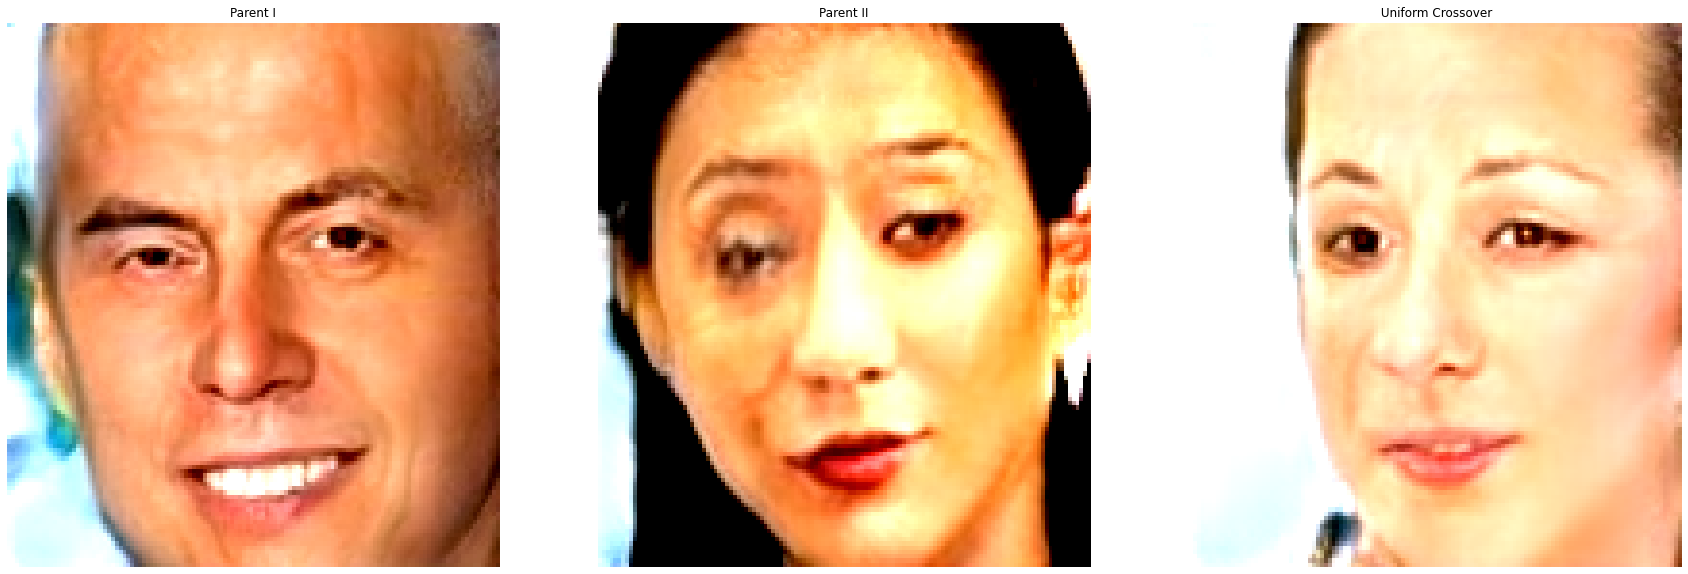

In [15]:
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.imshow(progan(z1)['default'][0],aspect='auto'),plt.axis('off')
plt.title('Parent I')
plt.subplot(132)
plt.imshow(progan(z2)['default'][0],aspect='auto'),plt.axis('off')
plt.title('Parent II')
plt.subplot(133)
plt.imshow(progan(crossover)['default'][0],aspect='auto'),plt.axis('off')
plt.title(' Uniform Crossover')

Now wrap up the Crossover process since we will be using it into the Deep Interactive Evolution algorithm

In [16]:
def uniform_crossover(population):
  # Gerate a population of vectors of size pop_len X latent_dim
  pop_len = 10
  population = tf.random.normal([pop_len,latent_dim])

  # Select two parents randomly from the population
  z1 = population[np.random.randint(0, pop_len)]
  z1 = population[np.random.randint(0, pop_len)]

  # Generate a binary mask using a binomial distribution with params n=1 p=0.5
  mask = np.random.binomial(1, 0.5, latent_dim)

  # Compute uniform crossover between the two parents
  crossover = mask*z1 + (1-mask)*z2

  return crossover

### Mutate: FILL THE CODE

```
# Questo è formattato come codice
```



Now we implement the process where a vector is randomly mutated

In [17]:

p = 0.5 # probability of mutation happening
mutate_var = 0.3 # variance of the normal distribution with with the embeddings
                  # are modified

def mutate(individual, mutate_var):
  # individual is a latent vector
  # Binomial distribution probability we want as output either zero or one with a 
  # 0.5 probability
  # FILL THE CODE: hint np.random.binomial
  mutate_cond = np.random.binomial(1, p, 1)

  # mutation noise
  # HINT np.random.randn
  noise = mutate_var*np.random.randn(1, latent_dim)

  # Mutated offspring, N.B. mutation happens depending on  mutate_cond
  mutated_offspring = individual + mutate_cond* noise

  return mutated_offspring

Generate a latent vector and its mutated offspring and look at the obtained images. Try different values for `mutate_rate` to see how the mutation changes.

In [18]:
z1 = tf.random.normal([latent_dim])

Text(0.5, 1.0, 'Mutation')

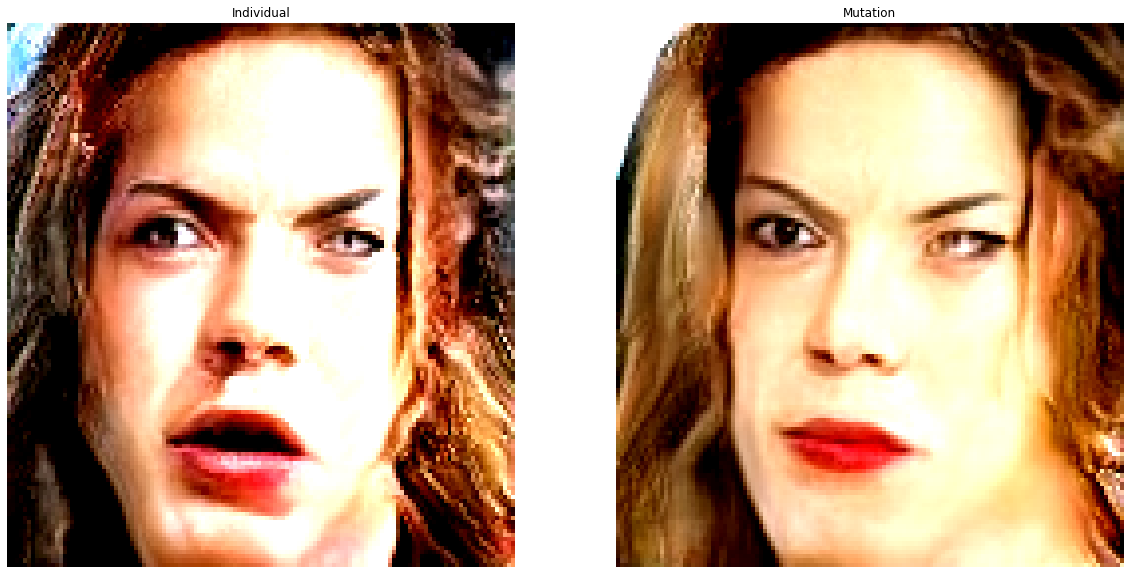

In [19]:
# apply mutation
mutated_z1 = mutate(z1,0.5)

# show results
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(progan(z1)['default'][0],aspect='auto'),plt.axis('off')
plt.title('Individual')
plt.subplot(122)
plt.imshow(progan(mutated_z1)['default'][0],aspect='auto'),plt.axis('off')
plt.title('Mutation')


### Evolve: FILL THE CODE

Now we finally define the function that will enable the evolution of our population

In [20]:
# number of foreign individuals (chromosomes) introduced at each iteration
foreign = 2 
n_pop = 10 # Population size

In [21]:
def evolve(z, indices, mutate_var, shuffle=True):
  """
  z: latent vectors corresponding to the members of the populations
  indices: indices of the selected latent vectors
  mutate_var: mutation rate
  shuffle: change presented vectors order
  """

  # Select the vectors that we want to preserve from the population: FILL THE CODE
  selections = z[indices]

  # Difference between total number of desired chromosomes and the selected ones
  diff = n_pop-len(selections)
  x = np.max([0, diff])

  # Perform uniform crossover and mutation: FILL THE CODE 
  cross = np.array([mutate(uniform_crossover(selections), mutate_var) for i in range(x - foreign)]).squeeze(axis=1)
 
  # Introduce new chromosomes/individuals!
  x = np.min((foreign,diff))
  new = np.random.randn(x,latent_dim) # new individual 

  # Apply mutation to selections
  selections = np.array([mutate(selection, mutate_var) for selection in selections]).squeeze(axis=1)


  # Stack together the population vectors
  z = np.vstack((selections, cross, new))

  # if not shuffle, the first n(selected) samples are mutated selected samples, 
    # the last n(foreign) samples are foreign samples, and all samples inbetween are crossovers
  if shuffle:
      np.random.shuffle(z) 
  return z

# Finally perform evolution!

First generate a population of latent vectors

In [25]:
z = tf.random.normal([n_pop,latent_dim])

Run the next two cells continuously to simulate the interactive evolution process

Start Img Generation


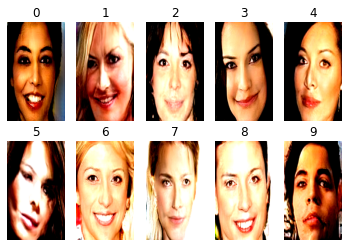

In [26]:
print('Start Img Generation')
for i in range(n_pop):
  imgs = progan(z[i])['default'][0]
  plt.subplot(2,int(n_pop/2),i+1)
  plt.imshow(imgs,aspect='auto')
  plt.title(str(i))
  plt.axis('off')

In [27]:
list_selected = [8, 0] # insert the indices of the samples you'd like to keep
z = evolve(z.numpy(), list_selected, mutate_var=0.2, shuffle=True)
z = tf.convert_to_tensor(tf.cast(z,dtype=tf.float32))

# Part II MusicVAE

We now repeat the same process only this time using MusicVae

In [28]:
#title Load the pre-trained model.
mel_2bar_config = configs.CONFIG_MAP['cat-mel_2bar_big']
model = TrainedModel(mel_2bar_config, batch_size=4, checkpoint_dir_or_path=BASE_DIR + '/checkpoints/mel_2bar_big.ckpt')

INFO:tensorflow:Building MusicVAE model with BidirectionalLstmEncoder, CategoricalLstmDecoder, and hparams:
{'max_seq_len': 32, 'z_size': 512, 'free_bits': 0, 'max_beta': 0.5, 'beta_rate': 0.99999, 'batch_size': 4, 'grad_clip': 1.0, 'clip_mode': 'global_norm', 'grad_norm_clip_to_zero': 10000, 'learning_rate': 0.001, 'decay_rate': 0.9999, 'min_learning_rate': 1e-05, 'conditional': True, 'dec_rnn_size': [2048, 2048, 2048], 'enc_rnn_size': [2048], 'dropout_keep_prob': 1.0, 'sampling_schedule': 'inverse_sigmoid', 'sampling_rate': 1000, 'use_cudnn': False, 'residual_encoder': False, 'residual_decoder': False, 'control_preprocessing_rnn_size': [256]}


INFO:tensorflow:Building MusicVAE model with BidirectionalLstmEncoder, CategoricalLstmDecoder, and hparams:
{'max_seq_len': 32, 'z_size': 512, 'free_bits': 0, 'max_beta': 0.5, 'beta_rate': 0.99999, 'batch_size': 4, 'grad_clip': 1.0, 'clip_mode': 'global_norm', 'grad_norm_clip_to_zero': 10000, 'learning_rate': 0.001, 'decay_rate': 0.9999, 'min_learning_rate': 1e-05, 'conditional': True, 'dec_rnn_size': [2048, 2048, 2048], 'enc_rnn_size': [2048], 'dropout_keep_prob': 1.0, 'sampling_schedule': 'inverse_sigmoid', 'sampling_rate': 1000, 'use_cudnn': False, 'residual_encoder': False, 'residual_decoder': False, 'control_preprocessing_rnn_size': [256]}


INFO:tensorflow:
Encoder Cells (bidirectional):
  units: [2048]



INFO:tensorflow:
Encoder Cells (bidirectional):
  units: [2048]



INFO:tensorflow:
Decoder Cells:
  units: [2048, 2048, 2048]



INFO:tensorflow:
Decoder Cells:
  units: [2048, 2048, 2048]



Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Do not call `graph_parents`.


Instructions for updating:
Do not call `graph_parents`.


INFO:tensorflow:Restoring parameters from gs://download.magenta.tensorflow.org/models/music_vae/colab2/checkpoints/mel_2bar_big.ckpt


INFO:tensorflow:Restoring parameters from gs://download.magenta.tensorflow.org/models/music_vae/colab2/checkpoints/mel_2bar_big.ckpt


In [29]:
z = np.random.randn(n_pop, latent_dim)

In [30]:
note_sequences = model.decode(
      length=32,
      z=z,
      temperature=0.8)

print('Start Seq Reconstruction')
for i in range(n_pop):
  print(str(i)) 
  play(note_sequences[i])

Start Seq Reconstruction
0


1


2


3


4


5


6


7


8


9


In [32]:
list_selected = [8, 0] # insert the indices of the samples you'd like to keep
z = evolve(z, list_selected, mutate_var=0.2, shuffle=True)